In [3]:
import gensim
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os
from typing import List, Tuple
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

# Set display options for pandas to see more data
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:
# --- Configuration ---
periods = [
    {
        "name": "Before 2016",
        "rep": "../../models/chunk_3/republican_before_2016.model",
        "dem": "../../models/chunk_3/democrats_before_2016.model"
    },
    {
        "name": "2017-2020",
        "rep": "../../models/chunk_3/republican_2017_2020.model",
        "dem": "../../models/chunk_3/democrats_2017_2020.model"
    },
    {
        "name": "2021-2024",
        "rep": "../../models/chunk_3/republican_2021_2024.model",
        "dem": "../../models/chunk_3/democrats_2021_2024.model"
    }
]

# Ideological Seeds to define the axis (Right - Left)
axis_seeds = [
    ("conservative", "liberal"),
    ("republican", "democrat")
]

In [5]:
# --- Helper Functions ---
def _normalize(v: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

def _get_neighbors(model, token: str, topn: int) -> List[str]:
    try:
        return [w for w, _ in model.wv.most_similar(token, topn=topn)]
    except KeyError:
        return []

def get_processed_vectors(model, words, center=True):
    vecs = np.array([model.wv[word] for word in words])
    if center:
        vecs = vecs - vecs.mean(axis=0)
    norm = np.linalg.norm(vecs, axis=1, keepdims=True)
    norm[norm == 0] = 1 
    return vecs / norm

In [6]:
def expand_seeds(
    model,
    human_seeds: List[Tuple[str, str]],
    top_k: int = 50,
    num_pairs: int = 10,
    min_count: int = 50,
    candidate_pool_limit: int = None,
    agg: str = "max",
    score_threshold: float = 0.3,
    verbose: bool = True
) -> List[Tuple[str, str]]:
    
    # Build allowed vocab if requested
    if candidate_pool_limit is not None:
        vocab_sorted = sorted(model.wv.index_to_key, key=lambda w: model.wv.get_vecattr(w, "count"), reverse=True)
        allowed_vocab = set(vocab_sorted[:candidate_pool_limit])
    else:
        allowed_vocab = None

    # Validate & build canonical seed directions
    seed_dirs = []
    valid_human_seeds = []
    for r_seed, l_seed in human_seeds:
        if r_seed in model.wv and l_seed in model.wv:
            v_r = _normalize(model.wv[r_seed])
            v_l = _normalize(model.wv[l_seed])
            seed_dirs.append(_normalize(v_r - v_l))
            valid_human_seeds.append((r_seed, l_seed))
        else:
            if verbose:
                print(f"[expand_seeds_matched] Warning: skipping seed ({r_seed}, {l_seed}) — missing from vocab")

    if len(seed_dirs) == 0:
        raise ValueError("No valid human seeds found in model vocabulary.")

    seed_dirs = np.stack(seed_dirs, axis=0)

    # Retrieve neighbors for each seed pair
    right_neighbors = {}
    left_neighbors = {}
    for r_seed, l_seed in valid_human_seeds:
        r_neigh = _get_neighbors(model, r_seed, top_k)
        l_neigh = _get_neighbors(model, l_seed, top_k)
        if allowed_vocab is not None:
            r_neigh = [w for w in r_neigh if w in allowed_vocab]
            l_neigh = [w for w in l_neigh if w in allowed_vocab]
        if min_count is not None:
            r_neigh = [w for w in r_neigh if model.wv.get_vecattr(w, "count") >= min_count]
            l_neigh = [w for w in l_neigh if model.wv.get_vecattr(w, "count") >= min_count]
        right_neighbors[(r_seed, l_seed)] = r_neigh
        left_neighbors[(r_seed, l_seed)] = l_neigh

    # Build candidate pairs
    candidate_pairs = set()
    for key in right_neighbors:
        for r in right_neighbors[key]:
            for l in left_neighbors[key]:
                if r == l: continue
                if min_count is not None:
                    if model.wv.get_vecattr(r, "count") < min_count or model.wv.get_vecattr(l, "count") < min_count:
                        continue
                candidate_pairs.add((r, l))
    candidate_pairs = list(candidate_pairs)
    
    if len(candidate_pairs) == 0:
        if verbose: print("No candidate pairs generated.")
        return valid_human_seeds[:num_pairs]

    # Precompute normalized vectors
    vocab_for_cache = set([w for pair in candidate_pairs for w in pair] + [w for sd in valid_human_seeds for w in sd])
    vec_cache = {w: _normalize(model.wv[w]) for w in vocab_for_cache if w in model.wv}

    # Score candidates
    records = []
    for (r, l) in candidate_pairs:
        vr = vec_cache.get(r)
        vl = vec_cache.get(l)
        if vr is None or vl is None: continue
        d_cand = _normalize(vr - vl)
        sims = seed_dirs.dot(d_cand)
        score = float(np.max(sims)) if agg == "max" else float(np.mean(sims))
        
        records.append({"r": r, "l": l, "score": score,
                        "freq_r": model.wv.get_vecattr(r, "count"),
                        "freq_l": model.wv.get_vecattr(l, "count")})

    df = pd.DataFrame(records).sort_values("score", ascending=False).reset_index(drop=True)

    # Greedy selection
    ban_list = [s for sd in valid_human_seeds for s in sd]
    selected = []
    i = 0
    while len(selected) < (num_pairs - len(valid_human_seeds)) and i < len(df):
        row = df.iloc[i]
        if row['r'] in ban_list or row['l'] in ban_list:
            i += 1
            continue
        if row['score'] < score_threshold:
            break
        selected.append((row['r'], row['l'], row['score'], row['freq_r'], row['freq_l']))
        ban_list.extend([row['r'], row['l']])
        i += 1

    final_pairs = list(valid_human_seeds) + [(r, l) for r, l, _, _, _ in selected]
    print(f'final pairs: {final_pairs}')
    return final_pairs[:num_pairs]

In [7]:
def align_models(model_base, model_target):
    """Aligns model_target to model_base using Iterative Procrustes."""
    # 1. Identify Common Vocabulary
    rep_vocab_sorted = sorted(model_base.wv.index_to_key, key=lambda w: model_base.wv.get_vecattr(w, "count"), reverse=True)
    dem_vocab_sorted = sorted(model_target.wv.index_to_key, key=lambda w: model_target.wv.get_vecattr(w, "count"), reverse=True)
    
    num_rep = int(0.6 * len(rep_vocab_sorted))
    num_dem = int(0.6 * len(dem_vocab_sorted))
    
    top_rep = set(rep_vocab_sorted[:num_rep])
    top_dem = set(dem_vocab_sorted[:num_dem])
    
    common_vocab = list(top_rep.intersection(top_dem))
    common_vocab.sort(key=lambda w: model_base.wv.get_vecattr(w, "count") + model_target.wv.get_vecattr(w, "count"), reverse=True)
    
    # 2. Rough Alignment
    initial_anchors = common_vocab[:3000]
    vecs_base_rough = get_processed_vectors(model_base, initial_anchors, center=True)
    vecs_target_rough = get_processed_vectors(model_target, initial_anchors, center=True)
    
    m = vecs_target_rough.T @ vecs_base_rough
    u, _, vt = np.linalg.svd(m)
    rotation_1 = u @ vt
    vecs_target_rotated = vecs_target_rough @ rotation_1
    
    # 3. Filter Anchors
    similarities = np.sum(vecs_base_rough * vecs_target_rotated, axis=1)
    distances = 1 - similarities
    anchor_scores = sorted(zip(initial_anchors, distances), key=lambda x: x[1])
    
    refined_anchors = [w for w, d in anchor_scores[:1500]]
    
    # 4. Final Alignment
    vecs_base_final = get_processed_vectors(model_base, refined_anchors, center=True)
    vecs_target_final = get_processed_vectors(model_target, refined_anchors, center=True)
    
    m_final = vecs_target_final.T @ vecs_base_final
    u_final, _, vt_final = np.linalg.svd(m_final)
    rotation_final = u_final @ vt_final
    
    model_target.wv.vectors = model_target.wv.vectors @ rotation_final
    
    mean_base = np.mean(model_base.wv[refined_anchors], axis=0)
    mean_target = np.mean(model_target.wv[refined_anchors], axis=0)
    model_target.wv.vectors = model_target.wv.vectors + (mean_base - mean_target)
    
    if hasattr(model_target.wv, 'fill_norms'):
        model_target.wv.fill_norms(force=True)
        
    return model_target, common_vocab

def construct_semantic_axis(model, seeds):
    axis_vectors = []
    for right, left in seeds:
        if right in model.wv and left in model.wv:
            v_r = model.wv[right]
            v_l = model.wv[left]
            v_r = v_r / np.linalg.norm(v_r)
            v_l = v_l / np.linalg.norm(v_l)
            axis_vectors.append(v_r - v_l)
            
    if not axis_vectors: return None
    
    final_axis = np.mean(axis_vectors, axis=0)
    final_axis = final_axis / np.linalg.norm(final_axis)
    return final_axis

In [8]:
# --- Main Execution ---

for period in periods:
    print(f"\n=== Processing Period: {period['name']} ===")
    
    # 1. Load Models
    print(f"Loading {period['rep']}...")
    try:
        model_rep = gensim.models.Word2Vec.load(period['rep'])
        model_dem = gensim.models.Word2Vec.load(period['dem'])
    except FileNotFoundError:
        print(f"Skipping {period['name']} - models not found.")
        continue
    
    # 2. Align Models
    print("Aligning models...")
    model_dem, common_vocab = align_models(model_rep, model_dem)
    
    # 3. Construct Axis
    current_seeds = expand_seeds(model_rep, axis_seeds, top_k=100, num_pairs=10, 
                                 min_count=50, candidate_pool_limit=20000, 
                                 agg='max', score_threshold=0.3)
    
    axis_vector = construct_semantic_axis(model_rep, current_seeds)
    if axis_vector is None:
        print("Error: Seeds not found.")
        continue
        
    # 4. Analyze Polarization
    num_anchors = int(0.8 * len(common_vocab))
    core_vocab = common_vocab[:num_anchors]
    
    results = []
    for word in core_vocab:
        v_rep = model_rep.wv[word]
        v_dem = model_dem.wv[word]
        
        v_rep = v_rep / np.linalg.norm(v_rep)
        v_dem = v_dem / np.linalg.norm(v_dem)
        
        proj_rep = np.dot(v_rep, axis_vector)
        proj_dem = np.dot(v_dem, axis_vector)
        polarization = abs(proj_rep - proj_dem)
        
        results.append({
            "word": word,
            "rep_score": proj_rep,
            "dem_score": proj_dem,
            "polarization": polarization
        })
        
    df = pd.DataFrame(results).sort_values("polarization", ascending=False)
    
    print(f"\n--- Top 15 Polarized Words ({period['name']}) ---")
    print(df.head(15)[['word', 'polarization', 'rep_score', 'dem_score']])


=== Processing Period: Before 2016 ===
Loading ../../models/chunk_3/republican_before_2016.model...
Aligning models...
final pairs: [('conservative', 'liberal'), ('republican', 'democrat'), ('gop', 'dems'), ('conservatism', 'leftist'), ('fiscal_conservative', 'lefty'), ('nutjob', 'sjw'), ('tea_party', 'libs'), ('evangelical', 'main_stream'), ('fiscal_conservatism', 'lib'), ('ted_cruz', 'bernie_sander')]

--- Top 15 Polarized Words (Before 2016) ---
                     word  polarization  rep_score  dem_score
3845        rick_santorum         0.529      0.257     -0.273
1093                 rand         0.454      0.339     -0.115
1037              leftist         0.454     -0.369      0.085
2139  fiscal_conservative         0.452      0.375     -0.078
4668   individual_liberty         0.449      0.342     -0.106
3813                  ron         0.437      0.237     -0.200
2065             gingrich         0.431      0.251     -0.180
3207           altogether         0.425      0.144

In [19]:
# --- Clustering & Visualization Functions ---

def perform_clustering_and_plot(df_results, period_name):
    """
    Runs HDBSCAN on (rep_score, dem_score) and plots the results.
    """
    print(f"Running HDBSCAN for {period_name}...")
    
    # 1. Prepare Data
    data = df_results[['rep_score', 'dem_score']].values
    
    # 2. Run HDBSCAN
    # min_cluster_size: Minimum size of a cluster (adjust if clusters are too small/large)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10)
    df_results['cluster'] = clusterer.fit_predict(data)
    
    # 3. Visualization
    plt.figure(figsize=(12, 10))
    
    # 1. Plot Noise (Grey) first so it stays in the background
    noise = df_results[df_results['cluster'] == -1]
    plt.scatter(noise['rep_score'], noise['dem_score'], c='lightgray', s=10, alpha=0.3, label='Noise')
    
    # 2. Plot Clusters using Seaborn (Fixes the color/number mismatch)
    clustered = df_results[df_results['cluster'] != -1]
    
    if not clustered.empty:
        sns.scatterplot(
            data=clustered,
            x='rep_score',
            y='dem_score',
            hue='cluster',         # Colors by cluster ID
            palette='tab10',       # Distinct colors
            s=20,
            legend='full'          # Forces a proper legend
        )
    
    plt.title(f'Semantic Clustering: {period_name}')
    plt.xlabel('Republican Alignment (Right -> Conservative)')
    plt.ylabel('Democrat Alignment (Right -> Conservative)')
    
    # Move legend to a nice spot so it doesn't cover data
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster ID")
    
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    return df_results

def analyze_cluster_frequencies(df_clustered, model_rep, model_dem):
    """
    Calculates how often each cluster is used by Reps vs Dems.
    """
    # Total token count estimates (sum of all vocab counts)
    total_rep = sum(model_rep.wv.get_vecattr(w, "count") for w in model_rep.wv.index_to_key)
    total_dem = sum(model_dem.wv.get_vecattr(w, "count") for w in model_dem.wv.index_to_key)
    
    stats = []
    
    for cluster_id, group in df_clustered.groupby('cluster'):
        if cluster_id == -1: continue # Skip noise
        
        words = group['word'].tolist()
        
        # Raw counts
        raw_rep = sum(model_rep.wv.get_vecattr(w, "count") for w in words if w in model_rep.wv)
        raw_dem = sum(model_dem.wv.get_vecattr(w, "count") for w in words if w in model_dem.wv)
        
        # Normalized Frequency (per million words)
        norm_rep = (raw_rep / total_rep) * 1_000_000
        norm_dem = (raw_dem / total_dem) * 1_000_000
        
        stats.append({
            "cluster": cluster_id,
            "size": len(words),
            "top_examples": ", ".join(words[:5]), # Just the first 5 words as examples
            "freq_rep_pm": round(norm_rep, 2),
            "freq_dem_pm": round(norm_dem, 2),
            "diff": round(norm_rep - norm_dem, 2)
        })
        
    return pd.DataFrame(stats).sort_values("diff", ascending=False)


=== Processing Period: Before 2016 ===
Aligning models...
final pairs: [('conservative', 'liberal'), ('republican', 'democrat'), ('gop', 'dems'), ('conservatism', 'leftist'), ('fiscal_conservative', 'lefty'), ('nutjob', 'sjw'), ('tea_party', 'libs'), ('evangelical', 'main_stream'), ('fiscal_conservatism', 'lib'), ('ted_cruz', 'bernie_sander')]
Running HDBSCAN for Before 2016...


c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


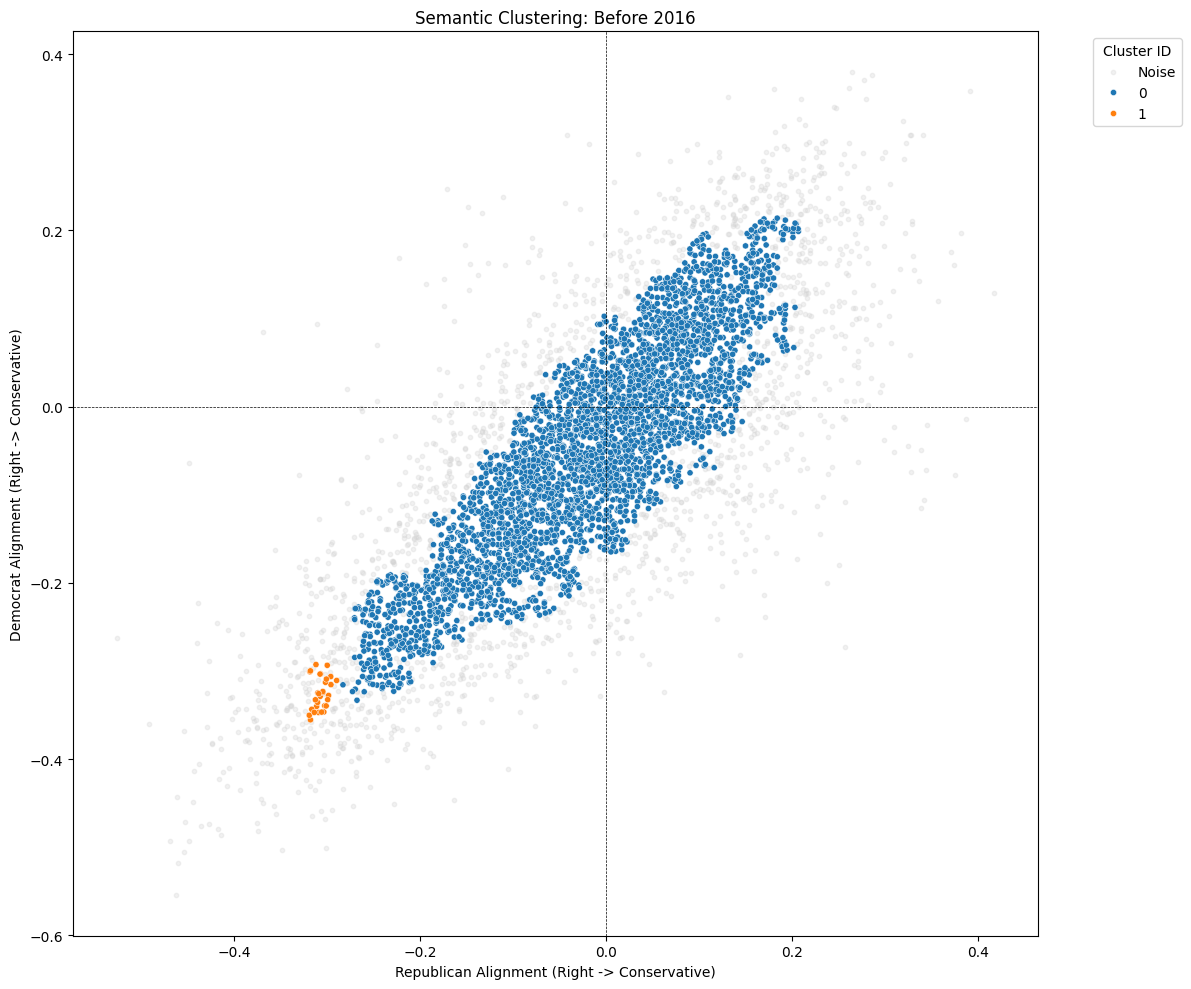

Analyzing Cluster Frequencies for Before 2016...

Cluster Statistics (Positive Diff = More Republican Usage):


,cluster,size,top_examples,freq_rep_pm,freq_dem_pm,diff
0,0,3583,"the, and, that, you, have",824732.830,811540.860,13191.980
1,1,30,"post, fucking, dumb, user, drink",1887.150,2612.190,-725.040



=== Processing Period: 2017-2020 ===
Aligning models...
final pairs: [('conservative', 'liberal'), ('republican', 'democrat'), ('gop', 'dems'), ('libertarian', 'leftist'), ('rand_paul', 'libs'), ('fiscal_conservative', 'libtards'), ('conservatism', 'white_guilt'), ('repub', 'dnc'), ('socially_liberal', 'lefty'), ('fiscally_conservative', 'brainwashed')]
Running HDBSCAN for 2017-2020...


c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


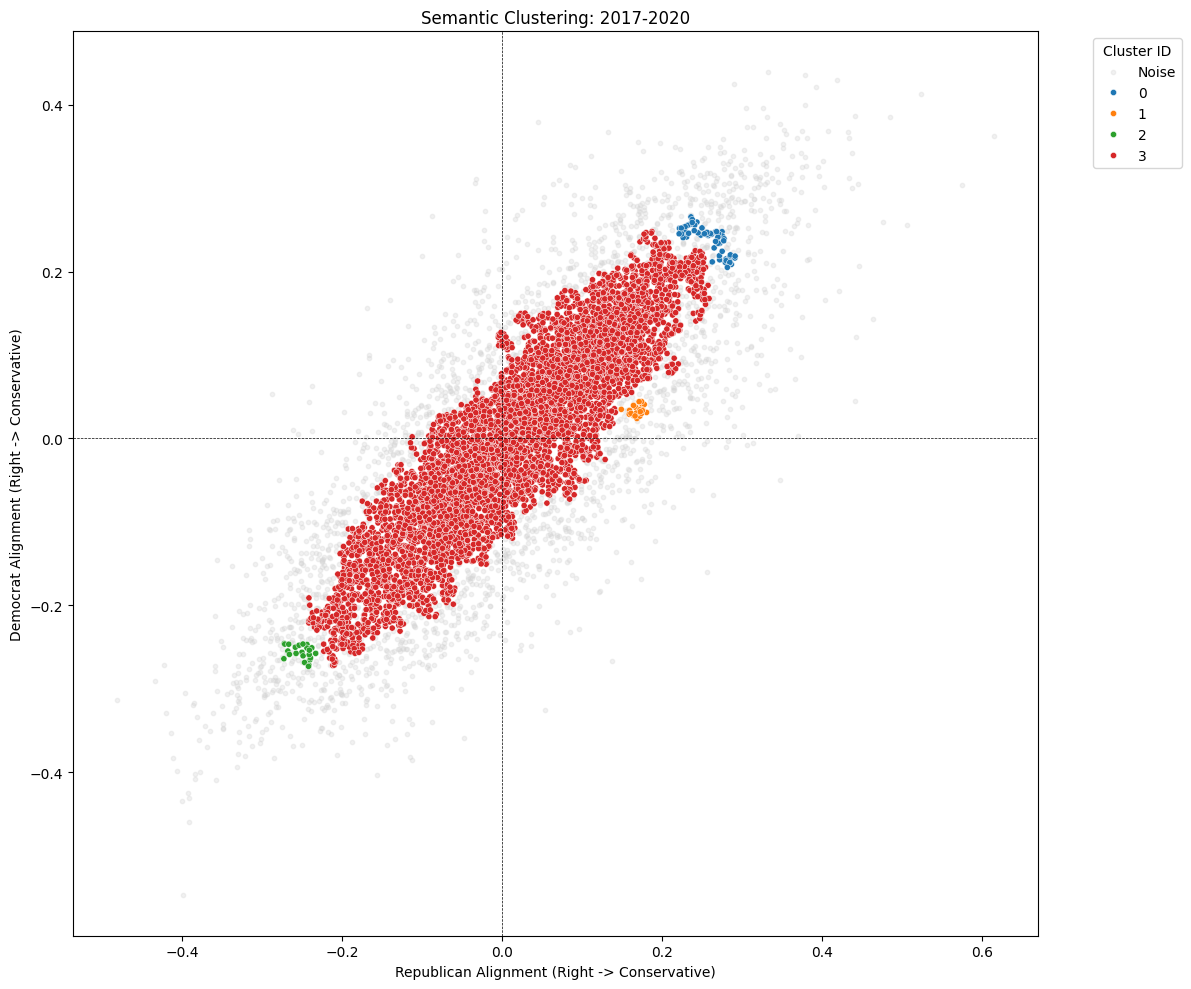

Analyzing Cluster Frequencies for 2017-2020...

Cluster Statistics (Positive Diff = More Republican Usage):


,cluster,size,top_examples,freq_rep_pm,freq_dem_pm,diff
3,3,5478,"the, and, that, you, have",874925.720,867132.780,7792.940
2,2,23,"narrative, constantly, fed, hack, drink",701.370,612.830,88.540
1,1,22,"fascism, superior, implication, common_ground,...",298.810,352.530,-53.710
0,0,63,"democratic, important, popular, immigration, a...",3383.250,4158.640,-775.400



=== Processing Period: 2021-2024 ===
Aligning models...
final pairs: [('conservative', 'liberal'), ('republican', 'democrat'), ('gop', 'dems'), ('libertarian', 'leftist'), ('anti_establishment', 'mindless'), ('populist', 'elitist'), ('romney', 'demonrats'), ('right_wing', 'leave_wing'), ('libertarians', 'lib'), ('conservatism', 'left')]
Running HDBSCAN for 2021-2024...


c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


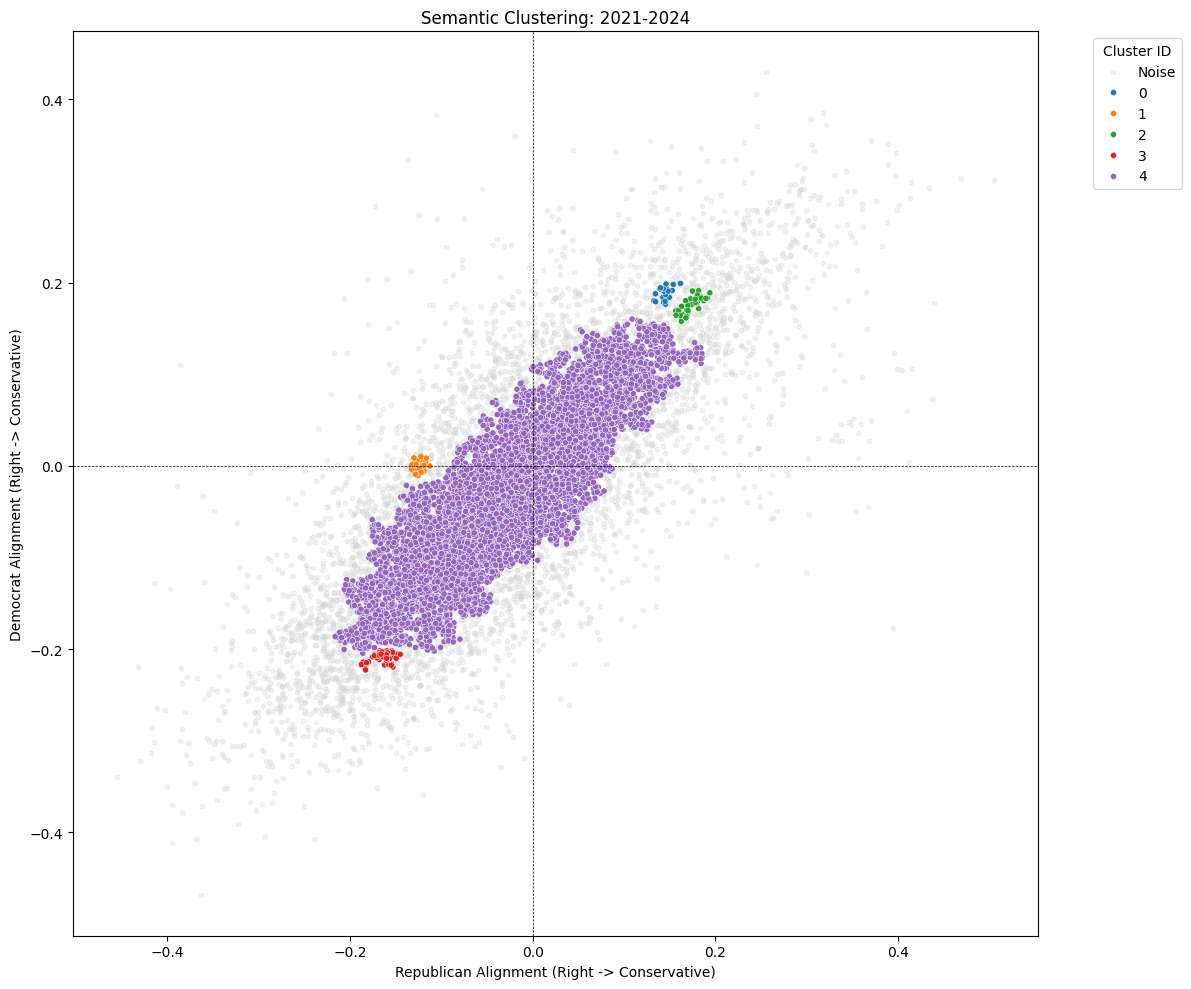

Analyzing Cluster Frequencies for 2021-2024...

Cluster Statistics (Positive Diff = More Republican Usage):


,cluster,size,top_examples,freq_rep_pm,freq_dem_pm,diff
4,4,5945,"the, and, that, they, you",786005.440,756299.290,29706.150
3,3,45,"laugh, bot, coward, outrage, illegal_immigrant",926.660,841.890,84.770
1,1,24,"game, genocide, mentally, thin, billboard",418.570,425.880,-7.310
0,0,23,"two, donate, key, sane, confident",1226.870,1554.180,-327.300
2,2,38,"think, good, agree, congress, whether",9533.240,10379.250,-846.010


In [20]:
# --- Main Execution (Updated) ---

all_period_stats = {}

for period in periods:
    print(f"\n=== Processing Period: {period['name']} ===")
    
    # 1. Load Models
    try:
        model_rep = gensim.models.Word2Vec.load(period['rep'])
        model_dem = gensim.models.Word2Vec.load(period['dem'])
    except FileNotFoundError:
        print(f"Skipping {period['name']} - models not found.")
        continue
    
    # 2. Align Models
    print("Aligning models...")
    model_dem, common_vocab = align_models(model_rep, model_dem)
    
    # 3. Construct Axis
    current_seeds = expand_seeds(model_rep, axis_seeds, top_k=100, num_pairs=10)
    axis_vector = construct_semantic_axis(model_rep, current_seeds)
    
    if axis_vector is None:
        continue
        
    # 4. Calculate Scores (Data Preparation)
    core_vocab = common_vocab[:int(0.8 * len(common_vocab))]
    results = []
    
    for word in core_vocab:
        v_rep = _normalize(model_rep.wv[word])
        v_dem = _normalize(model_dem.wv[word])
        
        proj_rep = np.dot(v_rep, axis_vector)
        proj_dem = np.dot(v_dem, axis_vector)
        
        results.append({
            "word": word,
            "rep_score": proj_rep,
            "dem_score": proj_dem,
            "polarization": abs(proj_rep - proj_dem)
        })
        
    df = pd.DataFrame(results)
    
    # --- NEW STEPS BELOW ---
    
    # 5. Clustering & Visualization
    df_clustered = perform_clustering_and_plot(df, period['name'])
    
    # 6. Frequency Analysis
    print(f"Analyzing Cluster Frequencies for {period['name']}...")
    cluster_stats = analyze_cluster_frequencies(df_clustered, model_rep, model_dem)
    
    print("\nCluster Statistics (Positive Diff = More Republican Usage):")
    display(cluster_stats) # Jupyter magic to show dataframe nicely
    
    all_period_stats[period['name']] = cluster_stats


=== Processing Period: Before 2016 ===
Aligning models...
final pairs: [('conservative', 'liberal'), ('republican', 'democrat'), ('gop', 'dems'), ('conservatism', 'leftist'), ('fiscal_conservative', 'lefty'), ('nutjob', 'sjw'), ('tea_party', 'libs'), ('evangelical', 'main_stream'), ('fiscal_conservatism', 'lib'), ('ted_cruz', 'bernie_sander')]
Running K-Means for Before 2016...


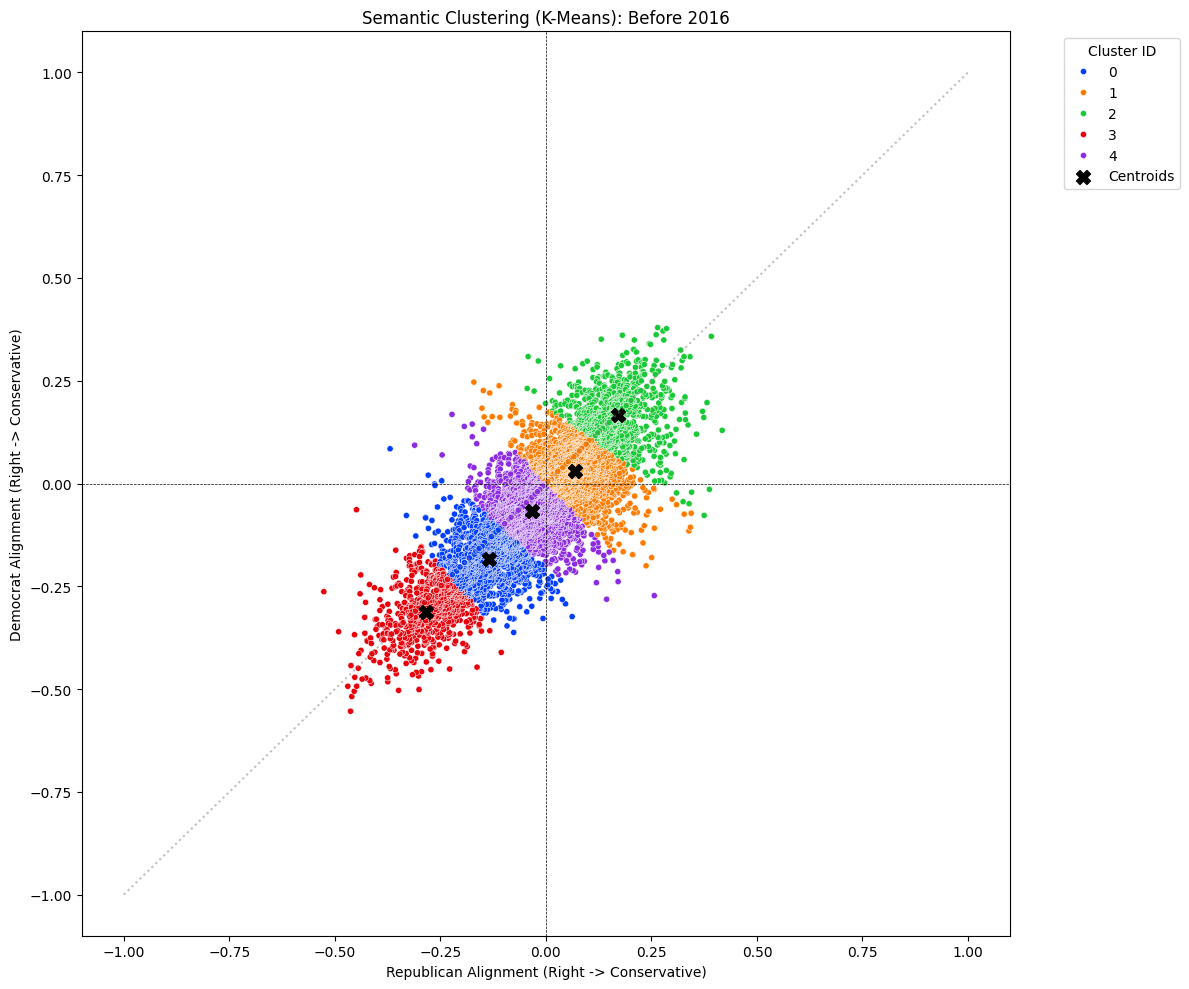

Analyzing Cluster Frequencies for Before 2016...

Cluster Statistics (Positive Diff = More Republican Usage):


,cluster,size,top_examples,freq_rep_pm,freq_dem_pm,diff
2,2,782,"fiscal_conservative, evangelical, fiscally_con...",302063.260,296595.900,5467.360
1,1,1411,"rand, individual_liberty, ron, gingrich, kaine",365728.300,364251.960,1476.340
4,4,1402,"rick_santorum, altogether, mitt, liberal, malley",209547.090,210787.370,-1240.280
0,0,1054,"leftist, administrator, expression, occurring,...",56332.640,62021.230,-5688.590
3,3,615,"heh, yep, tag, lefty, quit",26215.910,32416.910,-6201.010



=== Processing Period: 2017-2020 ===
Aligning models...
final pairs: [('conservative', 'liberal'), ('republican', 'democrat'), ('gop', 'dems'), ('libertarian', 'leftist'), ('rand_paul', 'libs'), ('fiscal_conservative', 'libtards'), ('conservatism', 'white_guilt'), ('repub', 'dnc'), ('socially_liberal', 'lefty'), ('fiscally_conservative', 'brainwashed')]
Running K-Means for 2017-2020...


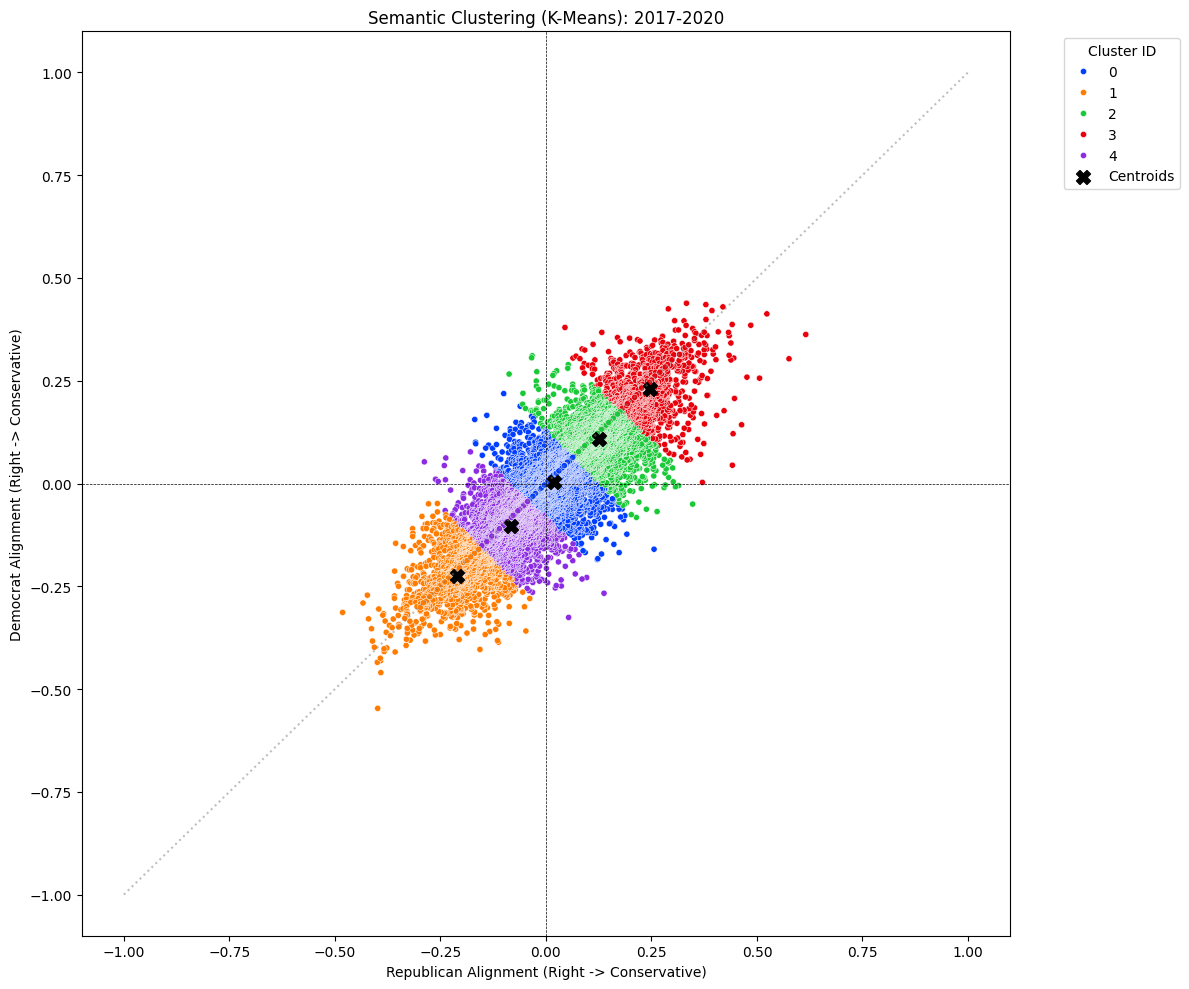

Analyzing Cluster Frequencies for 2017-2020...

Cluster Statistics (Positive Diff = More Republican Usage):


,cluster,size,top_examples,freq_rep_pm,freq_dem_pm,diff
4,4,1821,"web, rush_limbaugh, leftist, psychotic, jared",244944.300,239919.510,5024.790
1,1,1068,"donnie, donald, trumpers, maga, casino",72795.400,70969.330,1826.080
0,0,2057,"solve_problem, moscow, newsom, john_lewis, con",336858.060,335220.430,1637.630
3,3,838,"fiscal_conservatism, rubio, buttigieg, liberta...",51127.800,52829.280,-1701.480
2,2,1860,"evangelicals, organizer, abrams, bold, haley",268232.960,273331.770,-5098.810



=== Processing Period: 2021-2024 ===
Aligning models...
final pairs: [('conservative', 'liberal'), ('republican', 'democrat'), ('gop', 'dems'), ('libertarian', 'leftist'), ('anti_establishment', 'mindless'), ('populist', 'elitist'), ('romney', 'demonrats'), ('right_wing', 'leave_wing'), ('libertarians', 'lib'), ('conservatism', 'left')]
Running K-Means for 2021-2024...


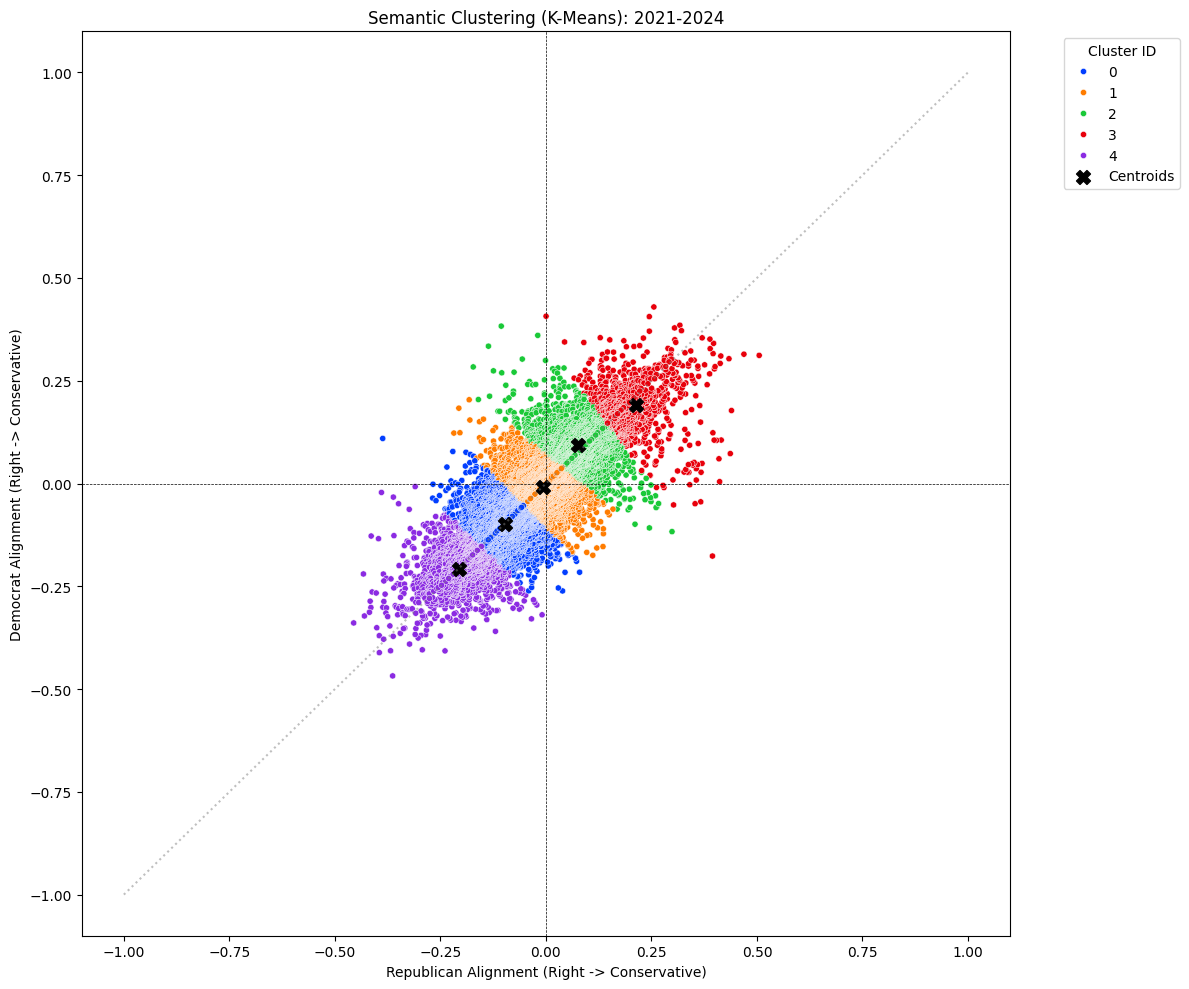

Analyzing Cluster Frequencies for 2021-2024...

Cluster Statistics (Positive Diff = More Republican Usage):


,cluster,size,top_examples,freq_rep_pm,freq_dem_pm,diff
1,1,2625,"social_justice, hochul, leftwing, activist, le...",316157.730,302661.430,13496.310
0,0,2517,"leftist, sean_hannity, san_francisco, greg_abb...",140408.410,127338.230,13070.180
4,4,1281,"left, lefty, schmuck, woke, virtue_signal",51909.850,48284.420,3625.430
2,2,2018,"whitmer, pritzker, schiff, maga, cooper",303126.340,313006.130,-9879.790
3,3,807,"pompeo, rand_paul, ron_desantis, warren, ramas...",165799.190,181190.650,-15391.460


In [27]:
from sklearn.cluster import KMeans

def perform_clustering_and_plot(df_results, period_name):
    """
    Runs K-Means on (rep_score, dem_score) and plots the results.
    """
    print(f"Running K-Means for {period_name}...")
    
    # 1. Prepare Data
    data = df_results[['rep_score', 'dem_score']].values
    
    # 2. Run K-Means
    # We choose 5 clusters to capture: 
    # (1) High-High, (2) Low-Low, (3) Mid-Mid, (4) High-Low, (5) Low-High
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    df_results['cluster'] = kmeans.fit_predict(data)
    
    # 3. Visualization
    plt.figure(figsize=(12, 10))
    
    # Plot using Seaborn
    sns.scatterplot(
        data=df_results,
        x='rep_score',
        y='dem_score',
        hue='cluster',         
        palette='bright',       # Bright colors to see the separation
        s=20,
        legend='full'
    )
    
    # Add centroids (The center of each cluster)
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, marker='X', label='Centroids')
    
    plt.title(f'Semantic Clustering (K-Means): {period_name}')
    plt.xlabel('Republican Alignment (Right -> Conservative)')
    plt.ylabel('Democrat Alignment (Right -> Conservative)')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster ID")
    
    # Add reference lines
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.plot([-1, 1], [-1, 1], color='gray', linestyle=':', alpha=0.5) # Diagonal line
    
    plt.tight_layout()
    plt.show()
    
    return df_results

# --- Main Execution (Updated) ---

all_period_stats = {}

for period in periods:
    print(f"\n=== Processing Period: {period['name']} ===")
    
    # 1. Load Models
    try:
        model_rep = gensim.models.Word2Vec.load(period['rep'])
        model_dem = gensim.models.Word2Vec.load(period['dem'])
    except FileNotFoundError:
        print(f"Skipping {period['name']} - models not found.")
        continue
    
    # 2. Align Models
    print("Aligning models...")
    model_dem, common_vocab = align_models(model_rep, model_dem)
    
    # 3. Construct Axis
    current_seeds = expand_seeds(model_rep, axis_seeds, top_k=100, num_pairs=10)
    axis_vector = construct_semantic_axis(model_rep, current_seeds)
    
    if axis_vector is None:
        continue
        
    # 4. Calculate Scores (Data Preparation)
    core_vocab = common_vocab[:int(0.8 * len(common_vocab))]
    results = []
    
    for word in core_vocab:
        v_rep = _normalize(model_rep.wv[word])
        v_dem = _normalize(model_dem.wv[word])
        
        proj_rep = np.dot(v_rep, axis_vector)
        proj_dem = np.dot(v_dem, axis_vector)
        
        results.append({
            "word": word,
            "rep_score": proj_rep,
            "dem_score": proj_dem,
            "polarization": abs(proj_rep - proj_dem)
        })
        
    df = pd.DataFrame(results)
    os.makedirs("../../output/axis", exist_ok=True)
    df = df.sort_values("polarization", ascending=False)
    df.to_csv(f"../../output/axis/{period['name']}.csv", index=False)
    
    # --- NEW STEPS BELOW ---
    
    # 5. Clustering & Visualization
    df_clustered = perform_clustering_and_plot(df, period['name'])
    
    # 6. Frequency Analysis
    print(f"Analyzing Cluster Frequencies for {period['name']}...")
    cluster_stats = analyze_cluster_frequencies(df_clustered, model_rep, model_dem)
    
    print("\nCluster Statistics (Positive Diff = More Republican Usage):")
    display(cluster_stats) # Jupyter magic to show dataframe nicely
    
    all_period_stats[period['name']] = cluster_stats

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load Data ---
# Replace these filenames with your actual file paths
df_2016 = pd.read_csv("../../output/axis/Before 2016.csv")
df_2020 = pd.read_csv("../../output/axis/2017-2020.csv")
df_2024 = pd.read_csv("../../output/axis/2021-2024.csv")

# Ensure we only have unique words per file to avoid merge errors
df_2016 = df_2016.drop_duplicates(subset='word')
df_2020 = df_2020.drop_duplicates(subset='word')
df_2024 = df_2024.drop_duplicates(subset='word')

# --- Helper Function to Analyze Change ---
def analyze_change(df_start, df_end, label_start, label_end):
    # Merge the two periods on 'word'
    merged = pd.merge(
        df_start[['word', 'polarization']], 
        df_end[['word', 'polarization']], 
        on='word', 
        suffixes=('_start', '_end')
    )
    
    # Calculate the change (Delta)
    # Positive = Became MORE polarized
    # Negative = Became LESS polarized
    merged['change'] = merged['polarization_end'] - merged['polarization_start']
    
    # Sort from biggest increase to biggest decrease
    merged = merged.sort_values('change', ascending=False)
    
    return merged

# --- 2. Perform Analysis ---
# Change 1: 2016 -> 2020
change_16_20 = analyze_change(df_2016, df_2020, "2016", "2020")
print(change_16_20.head(10))
# Change 2: 2020 -> 2024
change_20_24 = analyze_change(df_2020, df_2024, "2020", "2024")
print(change_20_24.head(10))
# --- 3. Save to CSV ---
change_16_20.to_csv("../../output/axis/polarization_change_16_to_20.csv", index=False)
change_20_24.to_csv("../../output/axis/polarization_change_20_to_24.csv", index=False)

print("Saved CSV files: 'polarization_change_16_to_20.csv' and 'polarization_change_20_to_24.csv'")

                word  polarization_start  polarization_end  change
3286             web               0.041             0.405   0.364
4844            bold               0.006             0.340   0.334
2462   rush_limbaugh               0.063             0.380   0.316
3946       editorial               0.026             0.309   0.283
4023  gerrymandering               0.024             0.262   0.239
2577         israeli               0.060             0.297   0.237
1817     nationalist               0.084             0.319   0.235
5014      nationwide               0.002             0.235   0.233
4716         tax_cut               0.008             0.238   0.230
4703         episode               0.009             0.228   0.220
                  word  polarization_start  polarization_end  change
306             pompeo               0.185             0.571   0.386
2850              left               0.064             0.368   0.304
490             schiff               0.161             0